# Javaria Ahmad 3001059

The goal of this project is to use anomaly detection models for finding anomalies in this data set. This is unsupervised machine learning. Real traffic dataset was used from https://www.kaggle.com/boltzmannbrain/nab. This dataset has speeds for vehicles captured  by different sensors. Anomalies in speeding data was found, or in other words, speeding violators were spotted.


To find anomalies, two approaches from sklearn were used: Isolation Forest and Local Outlier Factor. The results were obtained and compared from these two approaches.

References used: youtube.com/watch?v=gCWBFyFTxVU


In [161]:
# imports

%matplotlib inline

import sys
import numpy as np
from scipy import stats
import pandas as pd
import os
import matplotlib
import matplotlib.pyplot as plt
import sklearn
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn import preprocessing
import statsmodels.api as sm
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from sklearn.metrics import classification_report, accuracy_score
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor

import datetime
import seaborn as sns
import random
import glob, os

import warnings
warnings.filterwarnings("ignore")

Three different senors caught the speed values from multiple vehicles. These values were loaded into the dataframes. Then these values were concatenated into one dataframe. This dataframe was studied. In the dataset, there were 6122 records and two columns, that is, timestamp and speed value.


In [162]:

df_sensor1 = pd.read_csv('../data/raw/speed_6005.csv')
df_sensor2 = pd.read_csv('../data/raw/speed_7578.csv')
df_sensor3 = pd.read_csv('../data/raw/speed_t4013.csv')

df_speed = pd.concat([df_sensor1,df_sensor2,df_sensor3])
df_speed.shape

(6122, 2)

Top 5 values from the dataframe are below. It shows the spee values captured at different times.

In [163]:
df_speed.head()

,timestamp,value
0,2015-08-31 18:22:00,90
1,2015-08-31 18:32:00,80
2,2015-08-31 18:57:00,84
3,2015-08-31 19:07:00,94
4,2015-08-31 19:12:00,90


Cleaning the data by first replacing the missing values by NaN and then by dropping rows that contain Nan values. Then on finding the count of missing values, none were found.

In [164]:

df_speed = df_speed.replace('?', np.nan)

In [165]:
df_speed = df_speed.dropna()

In [166]:
df_speed[df_speed.isnull().any(axis=1)].count()

timestamp    0
value        0
dtype: int64

Printing the description of the data below. Value count is 6122, mean speeding value is ~71 mph. Maximum value found was 109 mph and lowest value was 1 mph.

In [167]:
print(df_speed.describe())

             value
count  6122.000000
mean     70.887128
std      11.912310
min       1.000000
25%      63.000000
50%      67.000000
75%      80.000000
max     109.000000


To group the values as anomaly or normal, the assumption was made that if speed is greater than 80, it is considered an anomaly (speeding case) and if spped is less than or equal to 80, it is considered a normal case.

A group column was created in the dataframe to group normal cases and to group anomaly cases. Group column was assigned 0 for normal cases and 1 for anomalies.


In [168]:
df_speed['group'] = df_speed['value']
df_speed.loc[df_speed['value'] >80, 'group'] = 1
df_speed.loc[df_speed['value'] <=80, 'group'] = 0

In [169]:
df_speed.head()

,timestamp,value,group
0,2015-08-31 18:22:00,90,1
1,2015-08-31 18:32:00,80,0
2,2015-08-31 18:57:00,84,1
3,2015-08-31 19:07:00,94,1
4,2015-08-31 19:12:00,90,1


Now plotting the histograms of speed values and group values to understand the data.

The group histogram shows that there are about 1500 speeding cases (1 values) and about 4500 normal cases (0 values). 
The histogram for value shows that most of the speed values are clustered between 50 and 100, more specifically, they are around 70.


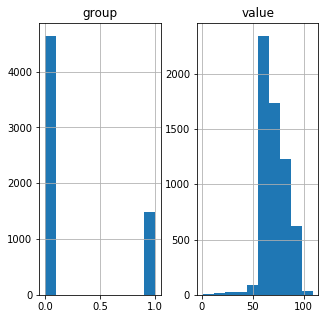

In [171]:
df_speed.hist(figsize=(5,5))
plt.show()

Found the number of speeding cases and normal cases. Also, found the anomaly (speeding) fraction to be used later in code. 32% of the cases are found to be the speeding cases.


In [172]:
speeding = df_speed[df_speed['group']==1]
normal = df_speed[df_speed['group']==0]

speeding_fraction = len(speeding)/float(len(normal))

print('Speeding cases: {}'.format(len(speeding)))
print('Normal cases: {}'.format(len(normal)))
print('Fraction of speeding cases: {}'.format(speeding_fraction))

Speeding cases: 1485
Normal cases: 4637
Fraction of speeding cases: 0.320250161743


Genarating a list of columns. Remove the coumns that are not needed, for example, remove the timestamp column because it does not add any value to our data and analysis. Also, remove the group column because it has a decision of normal and anomaly caeses. There will be prediction on the target column (group) in the next steps. Labels shouldn't be fed ahead of time since this is unsupervised learning.

The variable we are predicting (group) is Y and the speed is X.



In [173]:
fields = df_speed.columns.tolist()
fields = [c for c in fields if c not in ["group","timestamp"]]

X = df_speed[fields]
Y = df_speed["group"]

print(X.shape, Y.shape)

((6122, 1), (6122L,))


Outlier detection methods from Sklearn are used below. Creating dictionary of classifiers.

Local Outlier Factor is an unsupervised outlier detection method. It calculates the anomaly scores of each sample and that is called the local outlier factor. It measures the local deviation of density of a given sample with respect to its neighbors. We calculate anomaly scores based on the neighbors.

Isolation Factor isolates the observations by randomly selecting a feature and randomly selecting a split value between the maximum and minimum value of the selected feature.

In [174]:

dict_classfrs = {
    "Isolation Forest": IsolationForest(max_samples=len(X),
                                       contamination = speeding_fraction,
                                       random_state = 1),
    
    "Local Outlier Factor": LocalOutlierFactor(
    n_neighbors=20,
    contamination = speeding_fraction)    
}

Next, model fitting is done below and calculation metrics were found.

In [175]:

num_outliers = len(speeding)

for i, (classifier_name, classifier) in enumerate(dict_classfrs.items()):
    # Tag the outliers
    if classifier_name == "Local Outlier Factor":
        y_pred = classifier.fit_predict(X)
        scores_pred = classifier.negative_outlier_factor_
    else:
        classifier.fit(X)
        scores_pred = classifier.decision_function(X)
        y_pred = classifier.predict(X)
        
    # Keep prediction values 0 for normal and 1 for speeding
    y_pred[y_pred == 1] = 0
    y_pred[y_pred == -1] = 1
    
    # Find the number of errors in prediction
    num_errors = (y_pred != Y).sum()
    
    # Classification metrics
    print('{}:\n{}: {}'.format(classifier_name, "number of errors",num_errors))
    print('{}: {}'.format("accuracy score", accuracy_score(Y, y_pred)))
    print(classification_report(Y, y_pred))
    print("\n\n")

Local Outlier Factor:
number of errors: 1535
accuracy score: 0.749264946096
              precision    recall  f1-score   support

           0       0.76      0.98      0.86      4637
           1       0.31      0.03      0.05      1485

   micro avg       0.75      0.75      0.75      6122
   macro avg       0.54      0.50      0.45      6122
weighted avg       0.65      0.75      0.66      6122




Isolation Forest:
number of errors: 1094
accuracy score: 0.821300228683
              precision    recall  f1-score   support

           0       0.91      0.84      0.88      4637
           1       0.61      0.75      0.67      1485

   micro avg       0.82      0.82      0.82      6122
   macro avg       0.76      0.80      0.77      6122
weighted avg       0.84      0.82      0.83      6122






# Result Description:

In Local Outlier Factor, there were total of 1535 errors. The accuracy was 74%. 

The precision of two groups 0 and 1 was 0.76 and 0.31 respectively. 0.31 is low meaning that very few of speeding cases were actually labeled as speeding cases. Precision and recall values show that the model did not do well in cases of false positives and false negatives.

On the other hand, the Isolation Forest did a much better job by looking at the number of errors, accuracy score, and correctly labeling the cases as they are.